# 实验八 时间序列分析与预测

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.weightstats as sw
from sklearn.linear_model import LinearRegression
import scipy.stats as sta
import random


plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

## 1.时间序列的描述
根据我国2012-2017年的汽车产量(万辆)资料绘制时间序列折线图并计算汽车产量的增长量、平均增长量、发展速度和平均发展速度。

In [2]:
data = pd.read_excel('第10章  时间序列分析与预测.xlsx', None)

In [3]:
df1 = data['表10-8']
df1.columns = ['年份','我国汽车产量(万吨)']
df1

,年份,我国汽车产量(万吨)
0,2012,1927.62
1,2013,2212.09
2,2014,2372.52
3,2015,2450.00
4,2016,2812.00
5,2017,2902.00


### 折线图

<AxesSubplot:xlabel='年份'>

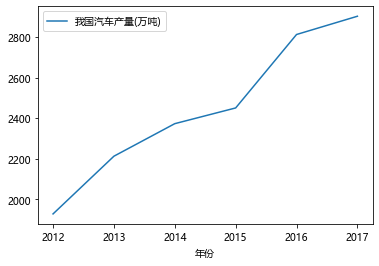

In [4]:
df1.plot(kind='line',x='年份',y='我国汽车产量(万吨)')

### 增长量

In [5]:
output_car = df1['我国汽车产量(万吨)'].values.flatten()
period_growth = [0]
accumulate_growth = [0]

for i in range(1,len(output_car)):
    period_growth.append(round(output_car[i] - output_car[i - 1],2))
    accumulate_growth.append(round(period_growth[i] + accumulate_growth[i - 1],2))

df2 = df1
df2['逐期增长量(万辆)'] = pd.Series(period_growth)
df2['累积增长量(万辆)'] = pd.Series(accumulate_growth)

df2 = df2.set_index('年份')
df2

,我国汽车产量(万吨),逐期增长量(万辆),累积增长量(万辆)
年份,,,
2012,1927.62,0.00,0.00
2013,2212.09,284.47,284.47
2014,2372.52,160.43,444.90
2015,2450.00,77.48,522.38
2016,2812.00,362.00,884.38
2017,2902.00,90.00,974.38


### 平均增长量

In [6]:
print('平均增长量为：{:.2f}'.format((df2.iloc[-1,0] - df2.iloc[0,0]) / 5))

平均增长量为：194.88


方法二:
```python
df1 = df1.set_index('年份')
growth = [df1.iloc[i + 1, 0] - df1.iloc[i, 0] for i in range(len(df1) - 1)]  # df1此时是以年份为索引，且只有一列
growth.insert(0,0)
acc = growth.copy()
for i in range(len(df1) - 1):
    acc[i + 1] += acc[i]
df1['增长量'] = growth
df1['累积增长量'] = acc
```

### 发展速度

In [7]:
speed1 = [0]
speed2 = [0]

for i in range(1,len(output_car)):
    speed1.append(round(output_car[i] / output_car[i - 1] * 100,1))
    speed2.append(round(output_car[i] / output_car[0] * 100,1))

df2['环比发展速度%'] = speed1
df2['定基发展速度%'] = speed2
df2

,我国汽车产量(万吨),逐期增长量(万辆),累积增长量(万辆),环比发展速度%,定基发展速度%
年份,,,,,
2012,1927.62,0.00,0.00,0.0,0.0
2013,2212.09,284.47,284.47,114.8,114.8
2014,2372.52,160.43,444.90,107.3,123.1
2015,2450.00,77.48,522.38,103.3,127.1
2016,2812.00,362.00,884.38,114.8,145.9
2017,2902.00,90.00,974.38,103.2,150.5


### 平均发展速度

In [8]:
avg_speed = (df2.iloc[-1,0] / df2.iloc[0,0]) ** 0.2 - 1
print('平均发展速度为：{:.2f}%'.format(avg_speed * 100))

平均发展速度为：8.53%


## 2.时间序列外推预测
根据某超市12周营业额数据绘制折线图，并使用移动平均法、指数平滑法和线性回归两种方法进行预测

In [9]:
df3 = data['表10-11']
df3.columns = ['月份','营业额（万元）']
df3

,月份,营业额（万元）
0,1,24
1,2,28
2,3,26
3,4,32
4,5,23
5,6,30
6,7,31
7,8,23
8,9,25
9,10,29


<AxesSubplot:xlabel='月份'>

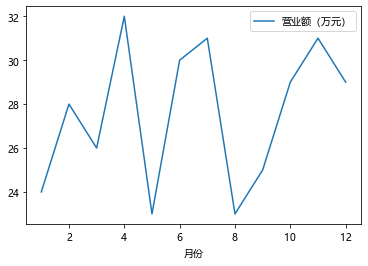

In [10]:
df3.plot(kind='line',x='月份',y='营业额（万元）')

### 2.1移动平均法

In [11]:
move_avg = [np.nan] * 3
t = 13

for i in range(1, len(df3) - 1):
    move_avg.append(round((df3.iloc[i - 1,1] + df3.iloc[i,1] + df3.iloc[i + 1,1]) / 3,6))

df3.loc[t - 1] = [13, np.nan]
df3['3次移动平均预测值'] = move_avg
df3['月份'] = df3['月份'].astype(int)
df3

,月份,营业额（万元）,3次移动平均预测值
0,1,24.0,NaN
1,2,28.0,NaN
2,3,26.0,NaN
3,4,32.0,26.000000
4,5,23.0,28.666667
5,6,30.0,27.000000
6,7,31.0,28.333333
7,8,23.0,28.000000
8,9,25.0,28.000000
9,10,29.0,26.333333


可以直接使用rolling方法   <br>
`df3['3次移动平均预测值'] = df3['营业额（万元）'].rolling(window=3).mean()` <br>
再将上述预测值与window=5计算的预测值进行对比、评估（可使用均方误差）。(~~这里偷懒不再实现了~~

### 2.2指数平滑法

In [12]:
exp_smooth = [np.nan,df3.iloc[0,1]]
a = 0.1
for i in range(1, len(df3) - 1):
    exp_smooth.append(round(a * df3.iloc[i,1] + (1 - a) * exp_smooth[-1],6))
df3['指数平滑预测值(a=0.1)'] = exp_smooth
df3

,月份,营业额（万元）,3次移动平均预测值,指数平滑预测值(a=0.1)
0,1,24.0,NaN,NaN
1,2,28.0,NaN,24.000000
2,3,26.0,NaN,24.400000
3,4,32.0,26.000000,24.560000
4,5,23.0,28.666667,25.304000
5,6,30.0,27.000000,25.073600
6,7,31.0,28.333333,25.566240
7,8,23.0,28.000000,26.109616
8,9,25.0,28.000000,25.798654
9,10,29.0,26.333333,25.718789


可以直接调用api计算
```python
from statsmodels.tsa.api import SimpleExpSmoothing
y = df3['营业额（万元）']
a = 0.1
fit1 = SimpleExpSmoothing(y).fit(smoothing_level=a,optimized=False)
fit1.forecast(1)  # 第13个周期的预测值
fit1.fittedvalues # 1 - 12 周期的预测值
```
同理可以取不同的a值，并比较均方误差，并选取最合适的a进行预测得到最后的结果

<AxesSubplot:title={'center':'实际值和移动平均预测值。指数平滑预测值对比'}, xlabel='月份'>

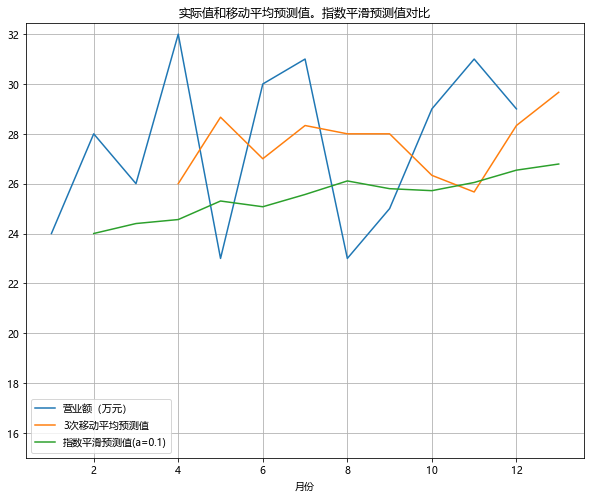

In [13]:
df3.plot(kind='line',x='月份',y=['营业额（万元）','3次移动平均预测值','指数平滑预测值(a=0.1)'],grid=True,figsize=(10,8),ylim=15,title='实际值和移动平均预测值。指数平滑预测值对比')

### 2.3线性回归预测
对表10-13中某公司2006-2017的销售额进行回归预测

In [14]:
df4 = data['表10-13']
df4.columns = ['年份','t','销售额实际观察值（万元）']
df4

,年份,t,销售额实际观察值（万元）
0,2006,1,490
1,2007,2,480
2,2008,3,510
3,2009,4,590
4,2010,5,570
5,2011,6,640
6,2012,7,680
7,2013,8,670
8,2014,9,690
9,2015,10,760


In [15]:
x = sm.add_constant(df4['t'])
y = df4.iloc[:,2]
model1 = sm.OLS(y,x)
res1 = model1.fit()
res1.summary()

d:\python\software\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           销售额实际观察值（万元）   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     245.9
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           2.28e-08
Time:                        09:11:45   Log-Likelihood:                -53.283
No. Observations:                  12   AIC:                             110.6
Df Residuals:                      10   BIC:                             111.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        444.2424     13.834     32.113      0.000     413.419     475.066
t             29.4755      1.880     15.681      0.000      25.287      33.664
==============================================================================
Omnibus:                        6.717   Durbin-Watson:                   2.688
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                1.490
Skew:                           0.178   Prob(JB):                        0.475
Kurtosis:                       1.311   Cond. No.                         15.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 线性趋势方程

In [16]:
k = res1.params[0]
b = res1.params[1]
print("线性趋势方程为：y = {:.2f} + {:.2f}t".format(k,b))

线性趋势方程为：y = 444.24 + 29.48t


### 预测值

In [17]:
y_pre = k + b * t
print("2018年销售额的预测值为：{:.2f}万元".format(y_pre))

2018年销售额的预测值为：827.42万元


## 3.季节变动预测
已有数据：某产品销售量（万件）在2015-2017年的季节数据

### 3.1计算季节指数

In [18]:
df5 = data['表10-16']
df5

,季度,2015,2016,2017
0,一,24,26,25
1,二,12,13,15
2,三,8,10,9
3,四,30,32,33


In [19]:
# df5.iloc[:,1:].mean(axis=1)   # 也可以实现
df5['同季平均数'] = df5.iloc[:,1:].apply(lambda x : round(x.sum() / len(x), 2), axis = 1)
df5

,季度,2015,2016,2017,同季平均数
0,一,24,26,25,25.00
1,二,12,13,15,13.33
2,三,8,10,9,9.00
3,四,30,32,33,31.67


In [20]:
season_avg =sum(df5['同季平均数'].values) / len(df5)
print("3年总的季平均数为：", season_avg)

3年总的季平均数为： 19.75


In [21]:
df5['季节指数%'] = df5['同季平均数'].values / season_avg * 100
df5

,季度,2015,2016,2017,同季平均数,季节指数%
0,一,24,26,25,25.00,126.582278
1,二,12,13,15,13.33,67.493671
2,三,8,10,9,9.00,45.569620
3,四,30,32,33,31.67,160.354430


### 3.2利用季节指数预测

In [22]:
df5['预测'] = df5['季节指数%'].values * 22.5 / 100  # 22.5 = 90 / 4   [90为2018年要达到的销售总量]
df5

,季度,2015,2016,2017,同季平均数,季节指数%,预测
0,一,24,26,25,25.00,126.582278,28.481013
1,二,12,13,15,13.33,67.493671,15.186076
2,三,8,10,9,9.00,45.569620,10.253165
3,四,30,32,33,31.67,160.354430,36.079747


## 4.Walmartdata.xls
Walmartdata.xls包含1994—2009年间沃尔玛的季度收益。使用移动平均比率法来预测2009年季度3季度和4季度以及2010年季度1和季度2的收益.使用季度49～季度60来创建一个用于预测的趋势估算

In [2]:
df6 = pd.read_excel('Walmartdata.xls',skiprows=9)
df6 = df6.iloc[:,4:]
df6

,Year,Quarter,season,Sales
0,1994,1,1,17686.000
1,1994,2,2,19942.315
2,1994,3,3,20417.717
3,1994,4,4,25365.968
4,1995,5,1,20440.000
...,...,...,...,...
61,2009,62,2,102342.000
62,2009,63,3,99473.000
63,2009,64,4,113651.000
64,2010,64,1,99848.000


### 移动平均比率法预测

In [3]:
table = pd.pivot_table(df6, index=['Year','season'], values = ['Sales'], aggfunc='sum')
table

Sales
Year season            
1994 1        17686.000
     2        19942.315
     3        20417.717
     4        25365.968
1995 1        20440.000
...                 ...
2009 2       102342.000
     3        99473.000
     4       113651.000
2010 1        99848.000
     2       103689.000

[66 rows x 1 columns]

In [4]:
table['移动平均n=4'] = table['Sales'].rolling(window=4).mean().shift(-2)
table['移动平均n=2'] = table.iloc[:,1].rolling(window=2).mean()
table['季节比率%'] = table['移动平均n=2'] / table['Sales'] * 100
table

Sales       移动平均n=4        移动平均n=2       季节比率%
Year season                                                     
1994 1        17686.000           NaN            NaN         NaN
     2        19942.315   20853.00000            NaN         NaN
     3        20417.717   21541.50000   21197.250000  103.817924
     4        25365.968   22236.67125   21889.085625   86.293122
1995 1        20440.000   22860.49200   22548.581625  110.315957
...                 ...           ...            ...         ...
2009 2       102342.000  102376.50000  101588.000000   99.263255
     3        99473.000  103828.50000  103102.500000  103.648729
     4       113651.000  104165.25000  103996.875000   91.505464
2010 1        99848.000           NaN            NaN         NaN
     2       103689.000           NaN            NaN         NaN

[66 rows x 4 columns]

In [5]:
avg_season = (table.groupby(by='season').sum() / (2010-1994))['季节比率%']

seasonal_index = pd.DataFrame(data={'季节指数%':avg_season / sum(avg_season) * 4 * 100})
seasonal_index

,季节指数%
season,
1,104.507482
2,98.147794
3,107.806826
4,89.537897


In [11]:
x = df6.iloc[:-4,1]
y = df6.iloc[:-4,-1]
X = sm.add_constant(x)
model2 = sm.OLS(y,X)
res2 = model2.fit()

x2 = list(range(63,67))
X2 = sm.add_constant(x2)
y_pre = res2.predict(X2)

season = seasonal_index.values
print("2009年季度3: {:.2f}".format(y_pre[0] * season[2][0] / 100))
print("2009年季度4: {:.2f}".format(y_pre[1] * season[3][0] / 100))
print("2010年季度1: {:.2f}".format(y_pre[2] * season[0][0] / 100))
print("2010年季度2: {:.2f}".format(y_pre[3] * season[1][0] / 100))

2009年季度3: 110344.41
2009年季度4: 92936.59
2010年季度1: 109981.38
2010年季度2: 104703.87


### 一个预测的趋势估算

In [28]:
df7 = df6.iloc[48:60,:]
t = pd.pivot_table(df7,index='season',columns='Year',values='Sales',aggfunc='sum')

t['同季平均数'] = t.iloc[:,:].mean(axis=1)
avg = t['同季平均数'].mean()
t['同季指数%'] = t['同季平均数'] / avg * 100
t

Year,2006,2007,2008,同季平均数,同季指数%
season,,,,,
1,79613.0,85387.0,86378.0,83792.666667,91.264076
2,84524.0,91990.0,92999.0,89837.666667,97.848081
3,83543.0,90880.0,91865.0,88762.666667,96.677229
4,100970.0,106269.0,107343.0,104860.666667,114.210614
